In [1]:
from pathlib import Path
import sqlite3

import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.style.use("default")

PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DB_PATH = PROJECT_ROOT / "data" / "processed" / "vbb_gtfs.db"
DB_PATH


WindowsPath('C:/Users/devra/germany-public-transport-analytics/data/processed/vbb_gtfs.db')

In [2]:
conn = sqlite3.connect(DB_PATH)
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;", conn
)
conn.close()
tables


,name
0,calendar
1,calendar_dates
2,delays
3,routes
4,stop_times
5,stops
6,trips


In [3]:
conn = sqlite3.connect(DB_PATH)

kpis = {}
kpis["n_routes"] = pd.read_sql_query("SELECT COUNT(*) AS c FROM routes;", conn)["c"][0]
kpis["n_trips"] = pd.read_sql_query("SELECT COUNT(*) AS c FROM trips;", conn)["c"][0]
kpis["n_stops"] = pd.read_sql_query("SELECT COUNT(*) AS c FROM stops;", conn)["c"][0]

conn.close()
pd.DataFrame(list(kpis.items()), columns=["metric", "value"])


,metric,value
0,n_routes,1322
1,n_trips,255389
2,n_stops,41927


In [4]:
conn = sqlite3.connect(DB_PATH)

sql_routes = """
SELECT
    r.route_id,
    r.route_short_name,
    r.route_long_name,
    COUNT(DISTINCT t.trip_id) AS n_trips
FROM routes r
JOIN trips t ON r.route_id = t.route_id
GROUP BY r.route_id, r.route_short_name, r.route_long_name
ORDER BY n_trips DESC
LIMIT 10;
"""
top_routes = pd.read_sql_query(sql_routes, conn)
conn.close()

top_routes


,route_id,route_short_name,route_long_name,n_trips
0,17452_900,M4,None,3112
1,17520_700,U6,None,3070
2,17514_400,U2,None,2893
3,17609_700,M4,None,2518
4,17453_700,M41,None,2246
5,17448_700,M27,None,2125
6,17440_900,M10,None,2098
7,17450_700,M32,None,1802
8,17449_700,M29,None,1749
9,17454_700,M44,None,1680


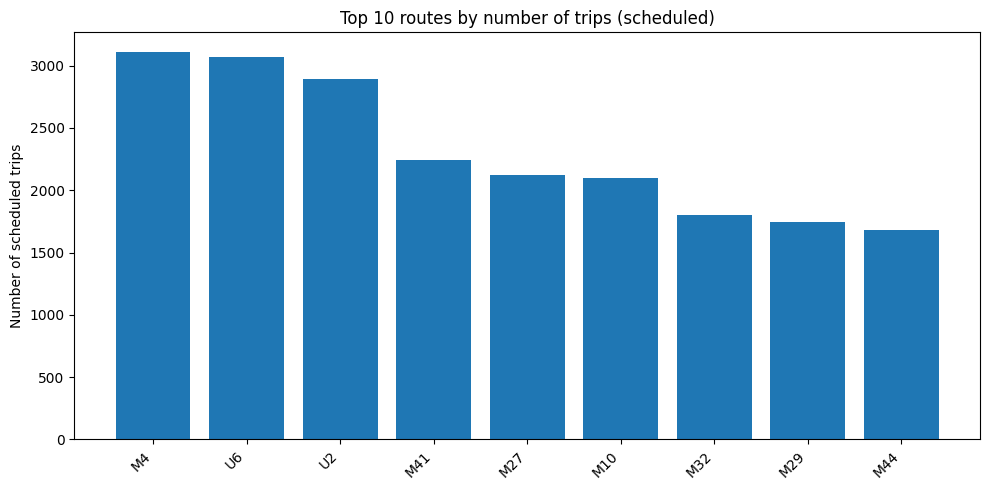

In [5]:
plt.figure(figsize=(10, 5))
x_labels = top_routes["route_short_name"].fillna(top_routes["route_id"].astype(str))
plt.bar(x_labels, top_routes["n_trips"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of scheduled trips")
plt.title("Top 10 routes by number of trips (scheduled)")
plt.tight_layout()
plt.show()


In [6]:
conn = sqlite3.connect(DB_PATH)

sql_stops = """
SELECT
    s.stop_id,
    s.stop_name,
    COUNT(*) AS n_arrivals
FROM stop_times st
JOIN stops s ON st.stop_id = s.stop_id
GROUP BY s.stop_id, s.stop_name
ORDER BY n_arrivals DESC
LIMIT 10;
"""
top_stops = pd.read_sql_query(sql_stops, conn)
conn.close()

top_stops


,stop_id,stop_name,n_arrivals
0,de:11000:900004181::3,Hertzallee (Berlin),5934
1,de:11000:900023201::5,S+U Zoologischer Garten Bhf (Berlin),5672
2,de:11000:900004181::2,Hertzallee (Berlin),5191
3,de:11000:900024203:1:51,S Savignyplatz (Berlin),4257
4,de:11000:900029202::1,"Berlin, Moritzstr.",3638
5,de:11000:900029302::4,S+U Rathaus Spandau (Berlin),3473
6,de:11000:900029202::2,"Berlin, Moritzstr.",3419
7,de:11000:900067221::3,S Lankwitz (Berlin),3337
8,de:11000:900096101::4,S+U Wittenau (Berlin),3311
9,de:11000:900100002::1,S Hackescher Markt (Berlin),3304


In [7]:
conn = sqlite3.connect(DB_PATH)

exists_delays = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table' AND name='delays';", conn
)
if exists_delays.empty:
    print("No 'delays' table yet.")
else:
    delay_kpis = pd.read_sql_query(
        """
        SELECT
            COUNT(*) AS n_events,
            AVG(delay_min) AS avg_delay_min,
            SUM(CASE WHEN delay_min > 5 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS share_over_5min,
            SUM(CASE WHEN delay_min <= 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS share_on_time_or_early
        FROM delays;
        """,
        conn,
    )
    display(delay_kpis)

conn.close()


,n_events,avg_delay_min,share_over_5min,share_on_time_or_early
0,6,6.833333,0.5,0.333333
